In [19]:
import re
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import Counter

from nltk.tokenize import sent_tokenize
from unidecode import unidecode
from rich import print

import seaborn as sns
from matplotlib.colors import TwoSlopeNorm
import matplotlib.pyplot as plt

def visualize_names(df, people=False, save=None):
    if people:
        df = df.loc[df.Nr_Words > 1, :]
    
    plt.figure(figsize=(12, 5))
    norm = TwoSlopeNorm(vmin=-1, vcenter=0.0, 
                        vmax=1)
    colors = [plt.cm.bwr(norm(c)) for c in df.Sentiment.head(15)]
    ax = sns.barplot(x='Sentiment', y='Word', data=df.head(15), palette=colors, edgecolor='black')
    plt.tight_layout()
    plt.xlabel("Sentiment")
    plt.ylabel("")
    
    if save:
        plt.savefig(f"../images/{save}.png", dpi=300)
    else:
        plt.show()
    
    
def preprocess_names(names, nr_sentences, title):
    df = pd.DataFrame(names, columns=["Word", "Prob", "Sentiment"])

    # Preprocessing
    df.Sentiment = df.Sentiment.map({"POSITIVE": 1, "NEGATIVE": -1})
    df.Word = [unidecode(word) for word in df.Word]
    df.Word = df.Word.str.replace('[^A-z]',' ').str.strip()
    df.Word = [re.sub(r"\b[a-zA-Z]\b", "", word).strip() for word in df.Word.values]
    df = df.loc[df.Word != "Disney", :]
    df = df.loc[df.Word.str.len() >= 3, :]
    df = df.loc[df.Prob > 0.9, :]

    # # Finishing up
    df = df.groupby("Word").agg({"Sentiment": [np.mean, np.count_nonzero]})
    df.columns = df.columns.droplevel()
    df = df.reset_index()
    df.columns = ["Word", "Sentiment", "Count"]
    df["Count_Percentage"] = df.Count / nr_sentences * 100
    df["Title"] = title
    df = df.sort_values("Count", ascending=False)
    df["Nr_Words"] = df.apply(lambda row: len(row.Word.split(" ")), 1)
    
    return df

def get_nr_sentences(docs):
    total_nr_sentences = 0
    for doc in docs:

        sentences = sent_tokenize(doc)
        total_nr_sentences += len(sentences)
    return total_nr_sentences

def extract_popular_characters(processed_names, sentences, names, name_in_title=False, min_sentences=1000):
    result = pd.DataFrame(columns=processed_names["Aladdin"].columns)

    for title in names:
        if sentences[title] >= min_sentences:
            to_append = processed_names[title]
            
            if not name_in_title:
                to_append = to_append.loc[to_append.Word != title, :]
                to_append = to_append.loc[~to_append.Word.isin(title.split(" "))]
            result = result.append(to_append)

    result = result.sort_values("Count_Percentage", ascending=False)
    
    return result

def visualize_top_characters(df, n=10, alternative_plot=False, save=False, people=False):
    data = df.copy()
    if people:
        data = data.loc[data.Nr_Words > 1, :]
    data["New_Title"] = data.Word + " --> " + data.Title
    data = data.head(n)

    # Create colors
    diverging_colors = [tuple(x) for x in sns.diverging_palette(12, 255, s=80, l=50, n=8)]
    bins = np.arange(-1, 1.1, .25)
    labels = [f"({round(x, 2)}, {round(x+2.5, 2)})" for x in np.arange(-10, 10, 2.5)]
    data["Color"] = pd.cut(data.Sentiment, bins = bins, labels = diverging_colors[::-1])
    
    # Visualize
    plt.figure(figsize=(12, 5))
    
    x = "Count_Percentage" if alternative_plot else "Sentiment"
    ax = sns.barplot(x=x, y='New_Title', data=data, palette=data.Color, edgecolor="black")
    plt.tight_layout()
    
#     xlabel = "Percentage" if alternative_plot else "Sentiment"
#     plt.xlabel("Percentage")

    
    plt.ylabel("")
    if save:
        plt.savefig(f"../images/{save}.png", dpi=300)
    else:
        plt.show()

**Load Data**

In [2]:
with open("../data/disney_names.json", "r") as f:
    names_per_movie = json.load(f)
    
with open("../data/disney_reviews.json", "r") as f:
    reviews_per_movie = json.load(f)

**Preprocess Data**

In [10]:
sentences_per_movie = {title: get_nr_sentences(reviews_per_movie[title]) for title in reviews_per_movie}
processed_names_per_movie = {title: preprocess_names(names_per_movie[title], sentences_per_movie[title], title) for title in names_per_movie}

**Visualize Names per Movie**

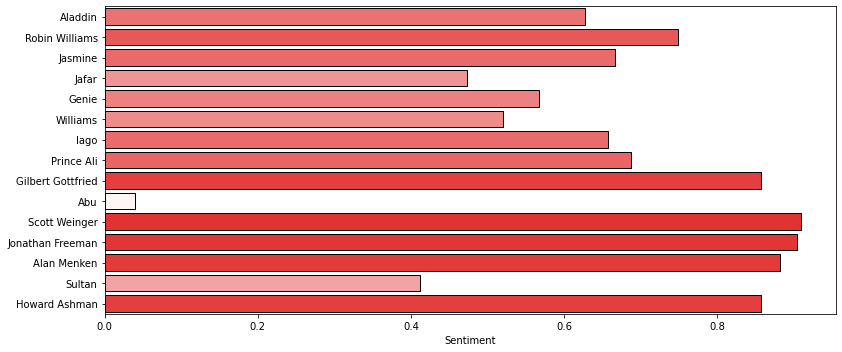

In [15]:
visualize_names(processed_names_per_movie["Aladdin"], save=None)

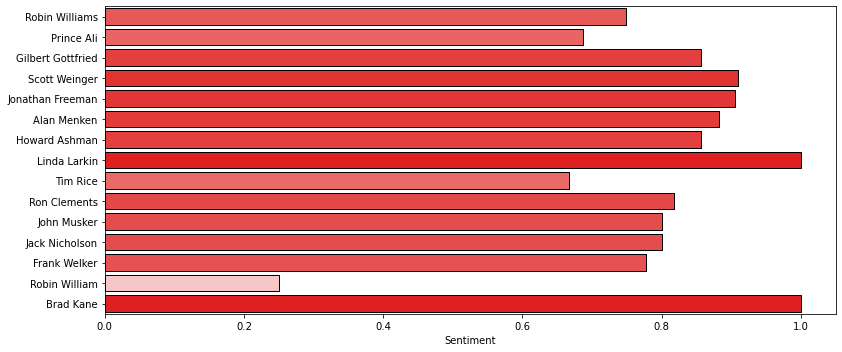

In [16]:
visualize_names(processed_names_per_movie["Aladdin"], save=None, people=True)

**Extract Popular Characters**

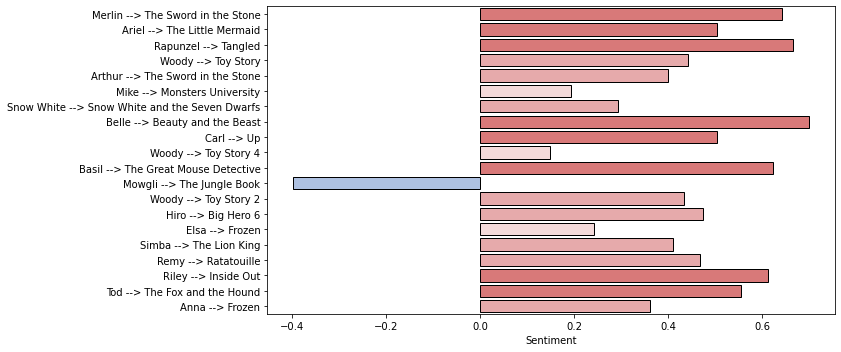

In [6]:
result = extract_popular_characters(processed_names_per_movie, sentences_per_movie, names_per_movie, 
                                    name_in_title=False, min_sentences=1000)
visualize_top_characters(result, n=20, save="popular_no_name_in_title")

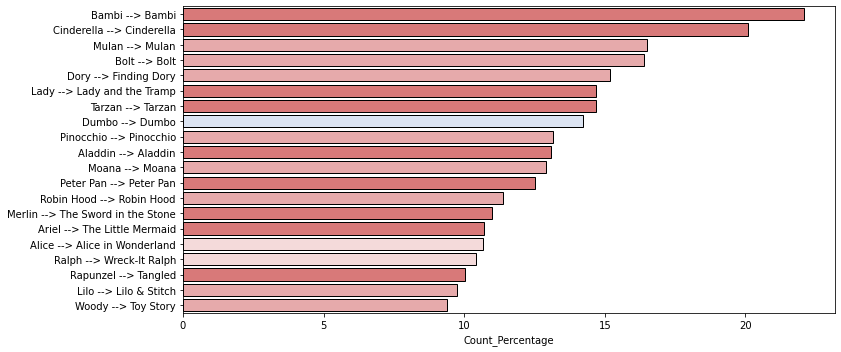

In [7]:
result = extract_popular_characters(processed_names_per_movie, sentences_per_movie, names_per_movie, 
                                    name_in_title=True, min_sentences=1000)
visualize_top_characters(result, n=20, alternative_plot=True, save="popular_no_name_in_title_alternative")

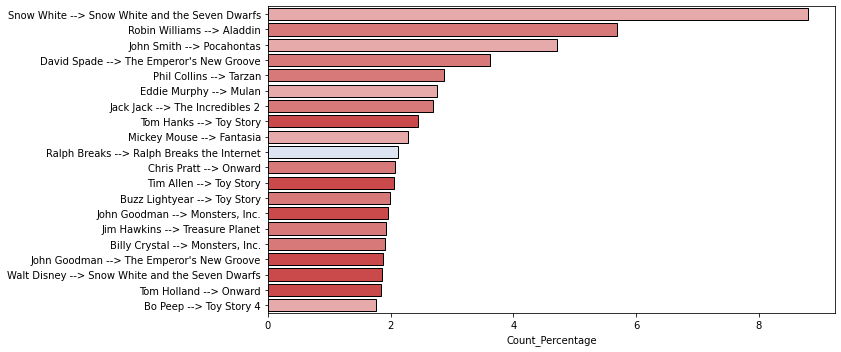

In [22]:
result = extract_popular_characters(processed_names_per_movie, sentences_per_movie, names_per_movie, 
                                    name_in_title=False, min_sentences=3000)
visualize_top_characters(result, n=20, alternative_plot=True, people=True)

**Name in Title**

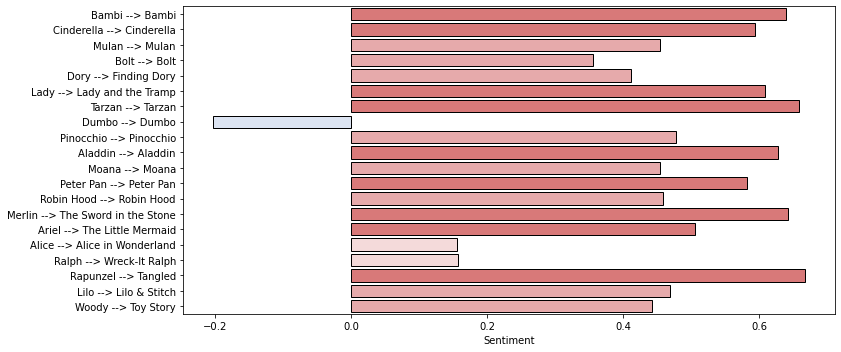

In [8]:
result = extract_popular_characters(processed_names_per_movie, sentences_per_movie, names_per_movie, 
                                    name_in_title=True, min_sentences=1000)
visualize_top_characters(result, n=20, save="popular_name_in_title")

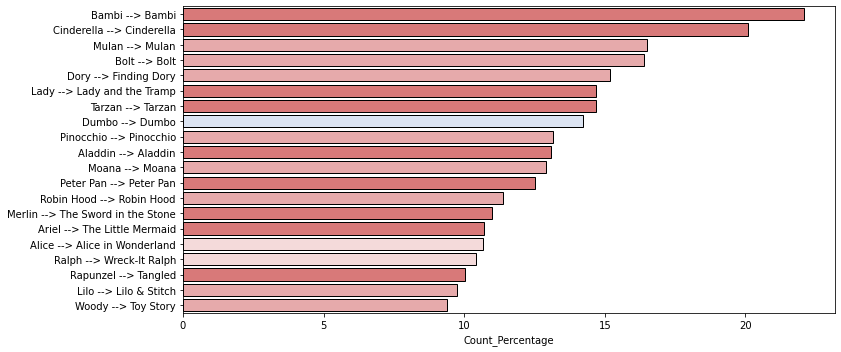

In [9]:
result = extract_popular_characters(processed_names_per_movie, sentences_per_movie, names_per_movie, 
                                    name_in_title=True, min_sentences=1000)
visualize_top_characters(result, n=20, alternative_plot=True, save="popular_name_in_title_alternative")

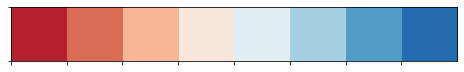

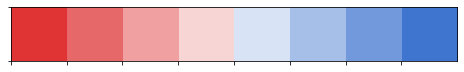

In [388]:
sns.palplot(sns.color_palette("RdBu", 8))
sns.palplot(sns.diverging_palette(12, 255, s=80, l=50, n=8))

In [ ]:
sent = pd.DataFrame.from_records([sentences_per_movie]).T.reset_index()
sent.columns = ["Title", "Nr_Sentences"]
sent.sort_values("Nr_Sentences", ascending=False)